In [83]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import datetime
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sample_data
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [84]:
df = pd.read_csv('inflation interest unemployment.csv')

In [85]:
df_usa = df[df['country'] == 'United States']

In [86]:
df_usa.head()

,country,year,"Inflation, consumer prices (annual %)","Inflation, GDP deflator (annual %)",Real interest rate (%),Deposit interest rate (%),Lending interest rate (%),"Unemployment, total (% of total labor force) (national estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",iso3c,iso2c,adminregion,incomeLevel
13156,United States,1970,5.838255,5.602170,2.185400,NaN,7.910000,4.9,NaN,USA,US,NaN,High income
13157,United States,1971,4.292767,5.069167,0.622605,NaN,5.723333,5.9,NaN,USA,US,NaN,High income
13158,United States,1972,3.272278,4.322751,0.887229,NaN,5.248333,5.6,NaN,USA,US,NaN,High income
13159,United States,1973,6.177760,5.479881,2.409735,NaN,8.021667,4.9,NaN,USA,US,NaN,High income
13160,United States,1974,11.054805,8.998695,1.651064,NaN,10.798333,5.6,NaN,USA,US,NaN,High income


In [87]:
df_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 13156 to 13207
Data columns (total 13 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   country                                                              52 non-null     object 
 1   year                                                                 52 non-null     int64  
 2   Inflation, consumer prices (annual %)                                52 non-null     float64
 3   Inflation, GDP deflator (annual %)                                   51 non-null     float64
 4   Real interest rate (%)                                               51 non-null     float64
 5   Deposit interest rate (%)                                            0 non-null      float64
 6   Lending interest rate (%)                                            52 non-null     float64
 7   Une

In [88]:
df_usa = df_usa.reset_index(drop = True)

In [89]:
#Delete columns that are not needed
columns_to_delete = ['Deposit interest rate (%)','iso3c', 'iso2c', 'country', 'adminregion', 'incomeLevel', 'Lending interest rate (%)', 'Unemployment, total (% of total labor force) (national estimate)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)']
df_usa.drop(columns=columns_to_delete, inplace=True)

In [90]:
df_usa.head()

,year,"Inflation, consumer prices (annual %)","Inflation, GDP deflator (annual %)",Real interest rate (%)
0,1970,5.838255,5.602170,2.185400
1,1971,4.292767,5.069167,0.622605
2,1972,3.272278,4.322751,0.887229
3,1973,6.177760,5.479881,2.409735
4,1974,11.054805,8.998695,1.651064


In [91]:
df_usa = df_usa.drop(index = 51, axis = 0)

In [92]:
#Rename to simply Inflation
df_usa = df_usa.rename(columns={"Inflation, consumer prices (annual %)": "Inflation"})

In [93]:
for i in range(len(df_usa.columns)):
  result = adfuller(df_usa[df_usa.columns[i]])

  if result[1] > 0.05:
    print('{} - Series is not stationary'.format(df_usa.columns[i]))
  else:
    print('{} - Series is stationary'.format(df_usa.columns[i]))

year - Series is not stationary
Inflation - Series is not stationary
Inflation, GDP deflator (annual %) - Series is not stationary
Real interest rate (%) - Series is not stationary


In [94]:
# Assuming df is your DataFrame with columns 'Year', 'InterestRate', and 'Inflation'
df_usa['Inflation_diff'] = df_usa['Inflation'].diff()

In [95]:
# Assuming df is your DataFrame with columns 'Year', 'InterestRate', and 'Inflation_diff'
seasonal_lag = 12  # Assuming a monthly seasonality, adjust as needed
df_usa['Inflation_seasonal_diff'] = df_usa['Inflation_diff'].diff(seasonal_lag)

In [96]:
# Assuming df is your DataFrame with columns 'Year', 'InterestRate', and 'Inflation_seasonal_diff'
window_size = 5
df_usa['Inflation_detrended'] = df_usa['Inflation_seasonal_diff'] - df_usa['Inflation_seasonal_diff'].rolling(window=window_size).mean()

In [97]:
df_usa = df_usa.dropna()  # Drop rows with missing values

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation_detrended'
X = df_usa[['Real interest rate (%)', 'year']]
y = df_usa['Inflation']

# Ensure that 'Inflation' is correctly named in your DataFrame
# If there is still an issue, print the columns to verify the names
# print(df_usa.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.0021083655774083


In [99]:
adf_test_result = adfuller(df_usa['Inflation'])

print('ADF Statistic:', adf_test_result[0])
print('p-value:', adf_test_result[1])
print('Critical Values:', adf_test_result[4])

# Check if the series is stationary based on the p-value
if adf_test_result[1] <= 0.05:
    print('The series is likely stationary.')
else:
    print('The series is likely non-stationary.')

ADF Statistic: -2.932548790547654
p-value: 0.04169183208759931
Critical Values: {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}
The series is likely stationary.


In [100]:
df_usa.head()

,year,Inflation,"Inflation, GDP deflator (annual %)",Real interest rate (%),Inflation_diff,Inflation_seasonal_diff,Inflation_detrended
17,1987,3.664563,2.472810,5.592238,1.766515,3.678173,4.832524
18,1988,4.077741,3.527421,5.590382,0.413178,3.811512,3.928860
19,1989,4.827003,3.920348,6.690687,0.749262,-0.007609,0.532978
20,1990,5.397956,3.743330,6.039749,0.570953,-0.558326,-0.638148
21,1991,4.234964,3.381762,4.915346,-1.162992,-4.786500,-5.213950


<Axes: xlabel='Real interest rate (%)', ylabel='Inflation'>

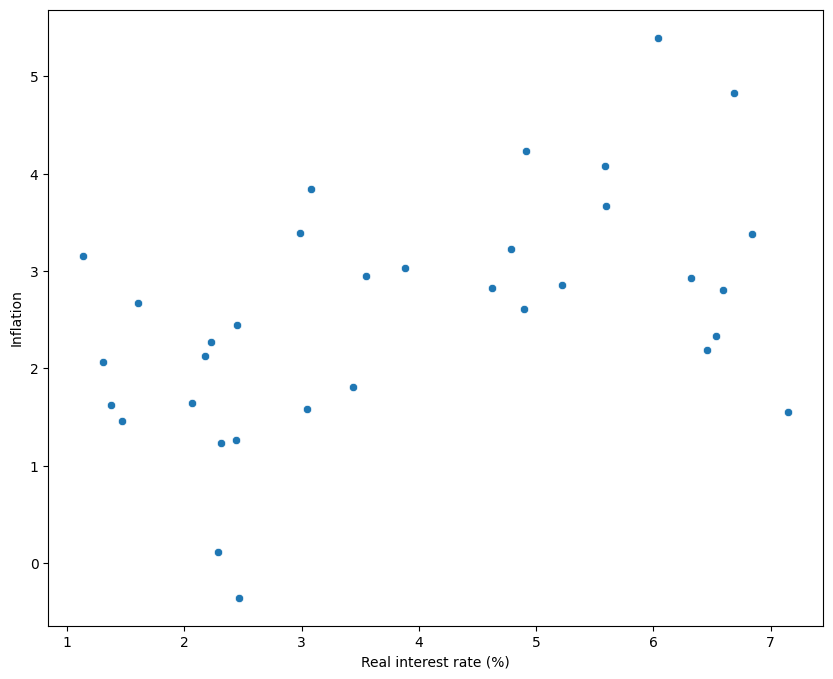

In [101]:
# visualizes the relationship between two variables
sns.scatterplot(data=df_usa, x="Real interest rate (%)", y="Inflation")

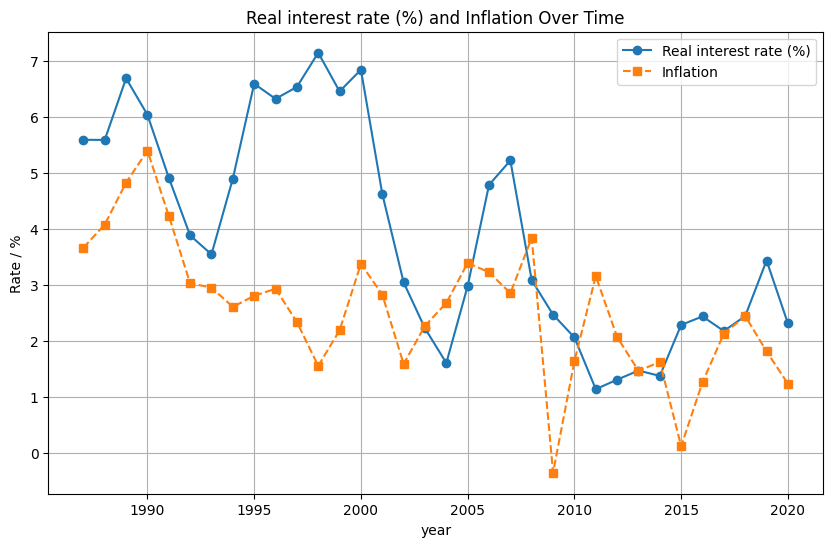

In [102]:
year = df_usa['year']
interest_rate = df_usa['Real interest rate (%)']
inflation = df_usa['Inflation']

# Create a line plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(year, interest_rate, label='Real interest rate (%)', marker='o', linestyle='-')
plt.plot(year, inflation, label='Inflation', marker='s', linestyle='--')

# Add labels and a title
plt.xlabel('year')
plt.ylabel('Rate / %')
plt.title('Real interest rate (%) and Inflation Over Time')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)  # Add grid lines
plt.show()

<Axes: xlabel='Real interest rate (%)', ylabel='Inflation'>

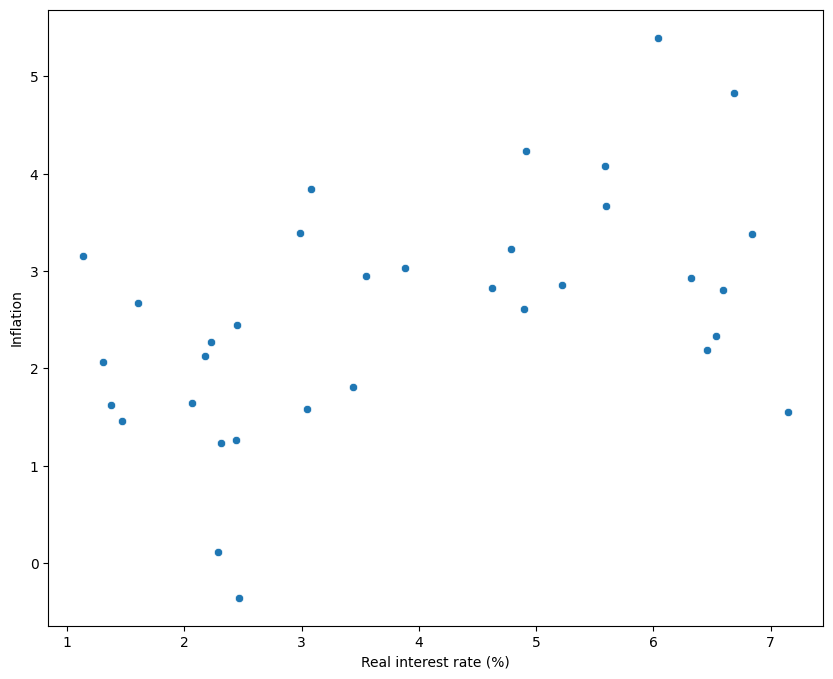

In [103]:
# visualizes the relationship between two variables
sns.scatterplot(data=df_usa, x="Real interest rate (%)", y="Inflation")

In [104]:

# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation'
model = VAR(df_usa[['Real interest rate (%)', 'year', 'Inflation']])
results = model.fit()
steps_ahead = 10
# Make predictions
forecast = results.forecast(df_usa[['Real interest rate (%)', 'year', 'Inflation']].values, steps=steps_ahead)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation_detrended'
X = df_usa[['Real interest rate (%)', 'year']]
y = df_usa['Inflation']

# Ensure that 'Inflation' is correctly named in your DataFrame
# If there is still an issue, print the columns to verify the names
# print(df_usa.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Function to predict inflation based on real interest rate
def predict_inflation(real_interest_rate):
    # Reshape the input to match the shape of the training data
    real_interest_rate = np.array(real_interest_rate).reshape(1, -1)
    inflation_prediction = model.predict(real_interest_rate)
    return inflation_prediction[0]

# Example usage
input_real_interest_rate = float(input("Enter real interest rate: "))
# Ensure the input is a single value
predicted_inflation = predict_inflation(np.array(input_real_interest_rate))
print(f"Predicted inflation: {predicted_inflation:.2f}")

<Axes: xlabel='Real interest rate (%)', ylabel='Inflation'>

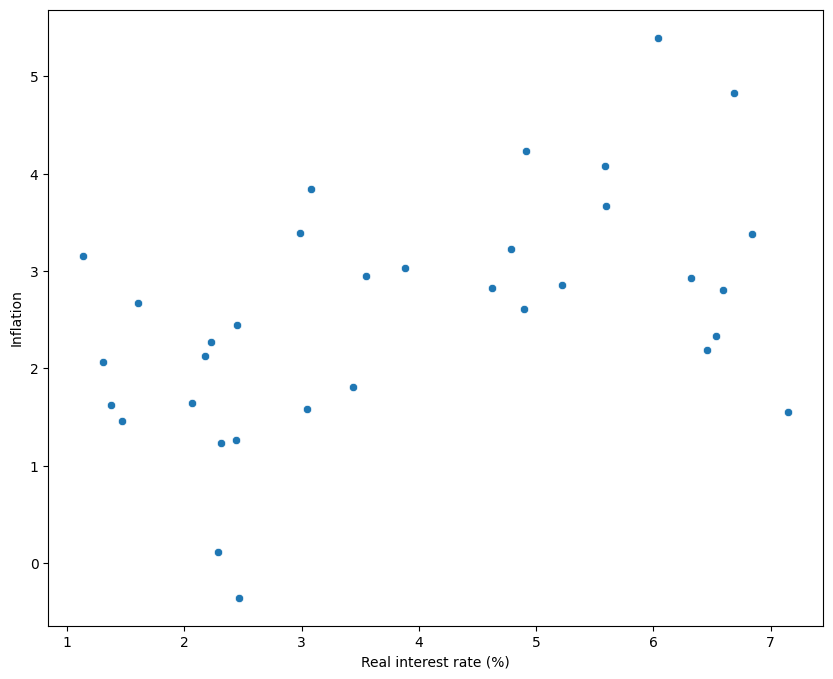

In [110]:
# visualizes the relationship between two variables
sns.scatterplot(data=df_usa, x="Real interest rate (%)", y="Inflation")

In [111]:
# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation_detrended'
model = VAR(df_usa[['Real interest rate (%)', 'year', 'Inflation']])
results = model.fit()
steps_ahead = 10

# Make predictions
forecast = results.forecast(df_usa[['Real interest rate (%)', 'year', 'Inflation']].values, steps=steps_ahead)

# Display the forecasted values
forecast_df = pd.DataFrame(forecast, columns=['Real interest rate (%)', 'year', 'Inflation'])

print("Forecasted Values for the Next 10 Steps:")
print(forecast_df)

Forecasted Values for the Next 10 Steps:
   Real interest rate (%)    year  Inflation
0                1.985088  2021.0   1.177076
1                1.708443  2022.0   1.098043
2                1.468985  2023.0   1.014578
3                1.256528  2024.0   0.930876
4                1.063434  2025.0   0.847742
5                0.884169  2026.0   0.765198
6                0.714764  2027.0   0.683121
7                0.552387  2028.0   0.601388
8                0.395017  2029.0   0.519903
9                0.241214  2030.0   0.438596


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


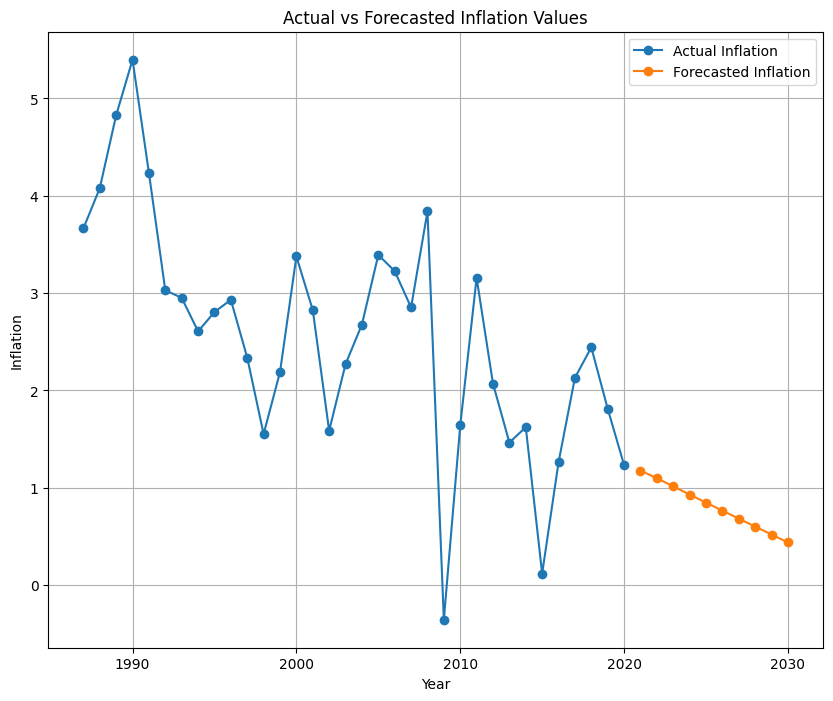

In [112]:
# Plot actual inflation values
plt.plot(df_usa['year'], df_usa['Inflation'], label='Actual Inflation', marker='o')

# Plot forecasted inflation values
plt.plot(range(df_usa['year'].max() + 1, df_usa['year'].max() + 1 + steps_ahead), forecast_df['Inflation'], label='Forecasted Inflation', marker='o')

plt.title('Actual vs Forecasted Inflation Values')
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend()
plt.grid(True)
plt.show()

Last Observations:
    Real interest rate (%)  year  Inflation_detrended
50                2.311111  2020            -1.474244

Predicted Inflation_detrended for the Next Step:
0.5064514289600766


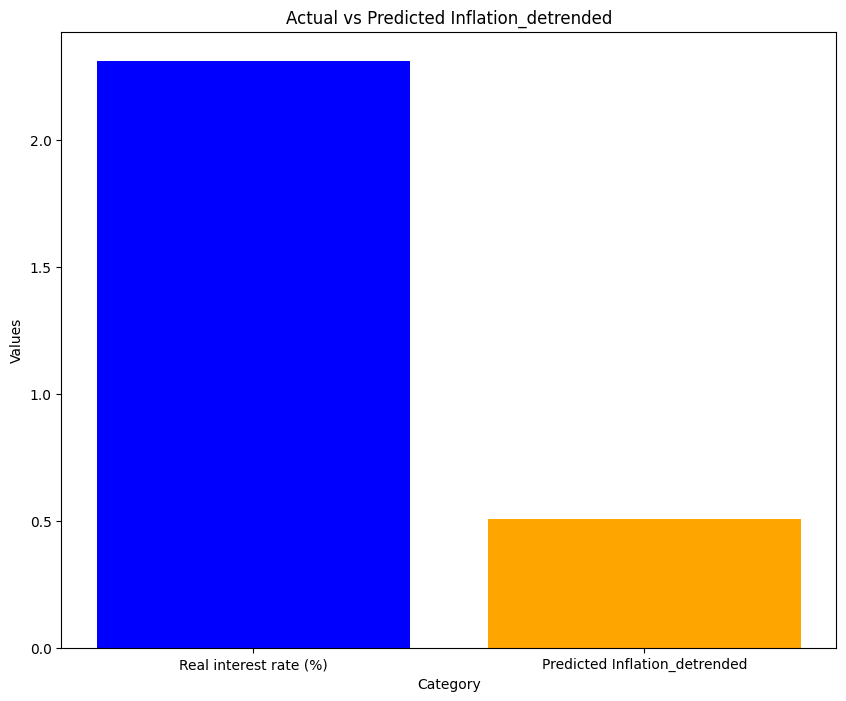

In [113]:
# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation_detrended'
# Also assuming you have already trained your VAR model and obtained the forecast

# Extract the lag order from the model
lag_order = results.k_ar

# Extract the last 'lag_order' observations for 'Real interest rate (%)', 'year', and 'Inflation_detrended'
last_observations = df_usa[['Real interest rate (%)', 'year', 'Inflation_detrended']].iloc[-lag_order:]

# Use the last observations to make a prediction for the next step
prediction_next_step = results.forecast(last_observations.values, steps=1)

# Extract the predicted value for 'Inflation_detrended'
predicted_inflation_detrended = prediction_next_step[0, -1]

# Display the values
print("Last Observations:")
print(last_observations)
print("\nPredicted Inflation_detrended for the Next Step:")
print(predicted_inflation_detrended)

# Plot the values
categories = ['Real interest rate (%)', 'Predicted Inflation_detrended']
values = [last_observations['Real interest rate (%)'].iloc[-1], predicted_inflation_detrended]

plt.bar(categories, values, color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Values')
plt.title('Actual vs Predicted Inflation_detrended')
plt.show()